In [30]:
from sklearn.metrics import confusion_matrix

def compute_sensitivity_specificity(y_true, y_pred):
    """
    Compute sensitivity and specificity from true labels and predictions.

    Parameters:
    y_true (list or array): True binary labels (0 or 1).
    y_pred (list or array): Predicted binary labels (0 or 1).

    Returns:
    dict: A dictionary with sensitivity and specificity.
    """
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {"Sensitivity": round(sensitivity,3), "Specificity": round(specificity,3)}

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def TableSubTypesErrors(morf_codificata, FoundFN_IDs, FoundFP_IDs, ids, size):
    # Create a DataFrame for the combined table
    unique_values = morf_codificata.unique()
    sorted_ids_errors = sorted(FoundFN_IDs + FoundFP_IDs, key=lambda x: int(x.split('_')[1]))
    table_df = pd.DataFrame({'patient': sorted_ids_errors})

    # Add columns for each unique value in morf_codificata and initialize with empty strings
    for value in sorted(map(int, unique_values)):
        table_df[value] = ''

    # Populate the DataFrame with 'x' for FN and FP with color labels
    for patient in FoundFN_IDs:
        if patient in ids.values:
            morf_value = morf_codificata[ids == patient].values[0]
            if morf_value in unique_values:
                table_df.loc[table_df['patient'] == patient, morf_value] = 'FN'
            else:
                print("There is a problem with FN!")
        else:
            print("Patient not found in FN IDs!")

    for patient in FoundFP_IDs:
        if patient in ids.values:
            morf_value = morf_codificata[ids == patient].values[0]
            if morf_value in unique_values:
                table_df.loc[table_df['patient'] == patient, morf_value] = 'FP'
            else:
                print("There is a problem with FP!")
        else:
            print("Patient not found in FP IDs!")

    if size == "Small":
        dim = (12, 8)
    else:
        dim = (18, 14)

    # Define colors for FP and FN
    color_map = {'FN': 'lightcoral', 'FP': 'lightblue'}
    cell_colors = [
        [color_map.get(cell, 'white') for cell in row]
        for row in table_df.iloc[:, 1:].values
    ]

    # Plotting the table without row labels
    fig, ax = plt.subplots(figsize=dim)
    ax.axis('tight')
    ax.axis('off')
    ax.table(
        cellText=table_df.values, colLabels=table_df.columns,
        cellLoc='center', loc='center', cellColours=[['white'] + color_row for color_row in cell_colors]
    )
    plt.title("Multi FN and FP Table")

    # Add description
    description = (
        "This table shows the distribution of false negatives (red) and false positives (blue) "
        "among different patient categories.\n"
        "Classes associated with label 1 (FN possible): {2, 3, 4}\n"
        "Classes associated with label 0 (FP possible): {0, 1, 5}"
    )
    fig.text(0.5, 0.8, description, ha='center', va='center', wrap=True, fontsize=12)

    plt.show()



In [32]:
   
    
'''
INPUT: PREDICTIONS, LABELS, AND SUBTYPES
OUTPUT: NONE (SHOWING THE STACKED HISTOGRAM OF ERRORS)
'''
def StackedHist(predictions, y_test,morf_codificata_test):
    # Calculate indices for correct predictions, false positives, and false negatives
    cp_index = (predictions == y_test)
    fp_index = (predictions == 1) & (y_test == 0)
    fn_index = (predictions == 0) & (y_test == 1)

    # Filter labels for CP, FP, and FN
    cp_labels = pd.Series(morf_codificata_test[cp_index])
    fp_labels = pd.Series(morf_codificata_test[fp_index])
    fn_labels = pd.Series(morf_codificata_test[fn_index])

    # Get value counts for CP, FP, and FN
    cp_counts = cp_labels.value_counts().sort_index()
    fp_counts = fp_labels.value_counts().sort_index()
    fn_counts = fn_labels.value_counts().sort_index()

    # Ensure all labels are present in each series
    all_labels = sorted(set(cp_counts.index) | set(fp_counts.index) | set(fn_counts.index))
    cp_counts = cp_counts.reindex(all_labels, fill_value=0)
    fp_counts = fp_counts.reindex(all_labels, fill_value=0)
    fn_counts = fn_counts.reindex(all_labels, fill_value=0)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))  # Width: 12 inches, Height: 10 inches

    # Stack CP, FP, and FN
    bars_cp = ax.bar(all_labels, cp_counts, label='Correct Predictions', color='green')
    bars_fp = ax.bar(all_labels, fp_counts, bottom=cp_counts, label='False Positives', color='orange')
    bars_fn = ax.bar(all_labels, fn_counts, bottom=cp_counts + fp_counts, label='False Negatives', color='blue')

    # Annotate each segment with its count
    def annotate_bars(bars, prev_heights=None, fontsize=10):
        for idx, bar in enumerate(bars):
            height = bar.get_height()
            y_position = height / 2 if prev_heights is None else prev_heights[idx] + height +2
            if height > 0:
                ax.annotate(f'{height}', (bar.get_x() + bar.get_width() / 2, y_position), ha='center', va='center', fontsize=fontsize,color='black')

    annotate_bars(bars_cp, fontsize=17)  # Increase font size for annotations
    annotate_bars(bars_fp, cp_counts.values, fontsize=17)
    annotate_bars(bars_fn, (cp_counts + fp_counts).values, fontsize=17)

    # Annotate each bin with the total count# Annotate each bin with the total count
    max_total  = 100
    total_offset = 0.08 * max_total  # You can adjust this value to change the space between the bar and the total count
    for idx, label in enumerate(all_labels):
        total = cp_counts[label] + fp_counts[label] + fn_counts[label]
        ax.annotate(f'Total: {total}', (idx, total + total_offset), ha='center', fontsize=12, color='black')  # Move total count further from the bar

    # Adjust y-limit based on the maximum total count
    max_total = max(cp_counts + fp_counts + fn_counts)
    ax.set_ylim([0, max_total + 0.1 * max_total])

    # Adding labels and title
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Stacked Histogram of Predictions')

    # Show legend and plot
    plt.legend()
    plt.tight_layout()
    plt.show()

# Fold 0

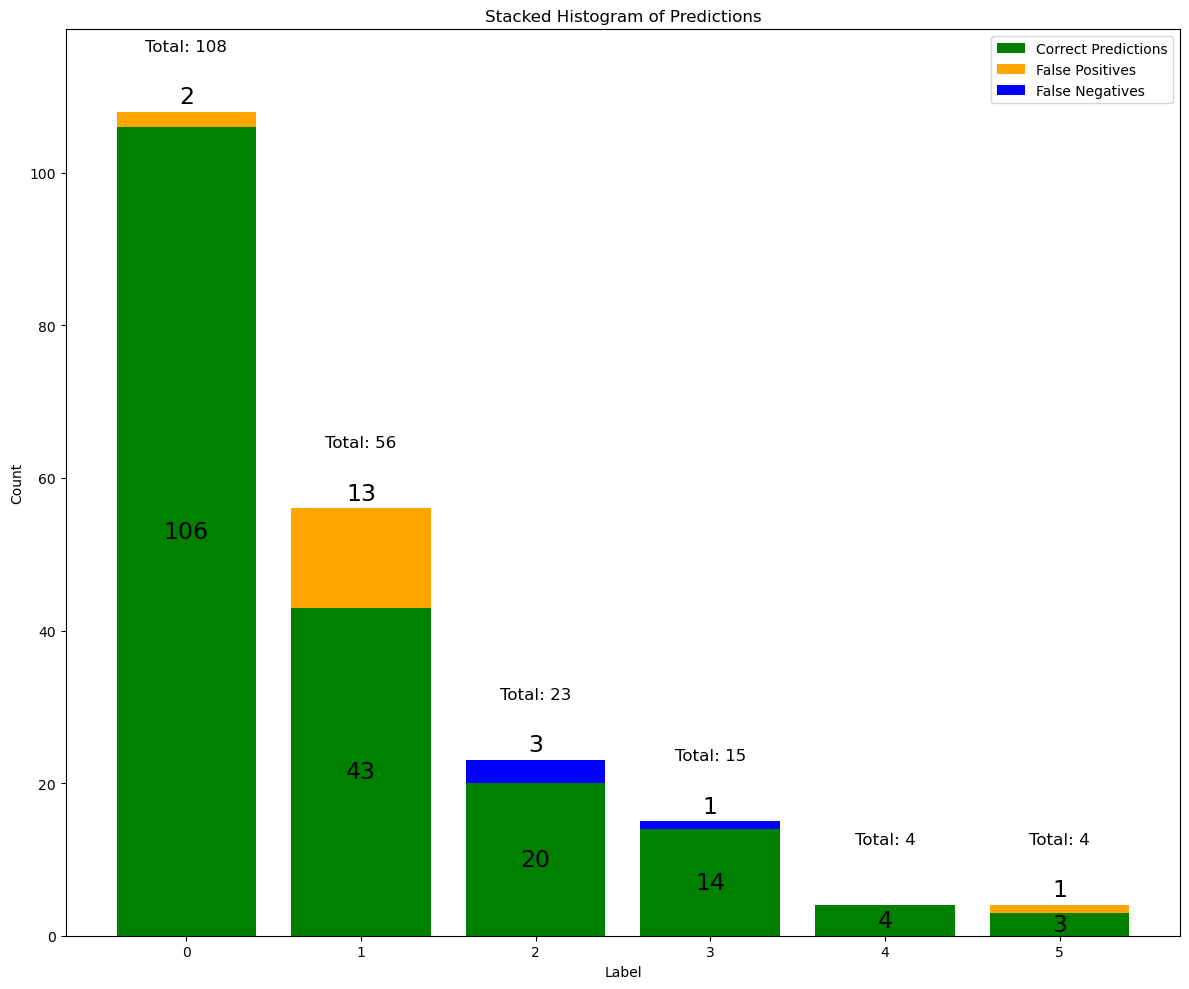

In [33]:
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
# Loading the dataset;
db = pd.read_csv("../nested_CV/fold_0_test_set.csv")
path = "../Elements/Boruta_RusBoost/AcrossSplits/Split0_Boruta_RusBoostFitted_pipeline.pkl"
# removing the id and the subtypes of a given dataset
def extract_PATIENT_INFO(db):
   ids =  db.pop("ID")
   morf_codificata = db.pop("morf_codificata")
   luogoTc= db.pop("luogoTC_codificato")
   return db, ids, morf_codificata, luogoTc

# extrating the label
y_test = db.pop("label")
X_test = db

loaded_pipeline = joblib.load(path) # to load the model


X_test, ids_test, morf_codificata_test, luogoTc = extract_PATIENT_INFO(X_test) #to remove the patient infos

predictions = loaded_pipeline.predict(X_test)
StackedHist(predictions=predictions, y_test=y_test, morf_codificata_test=morf_codificata_test)

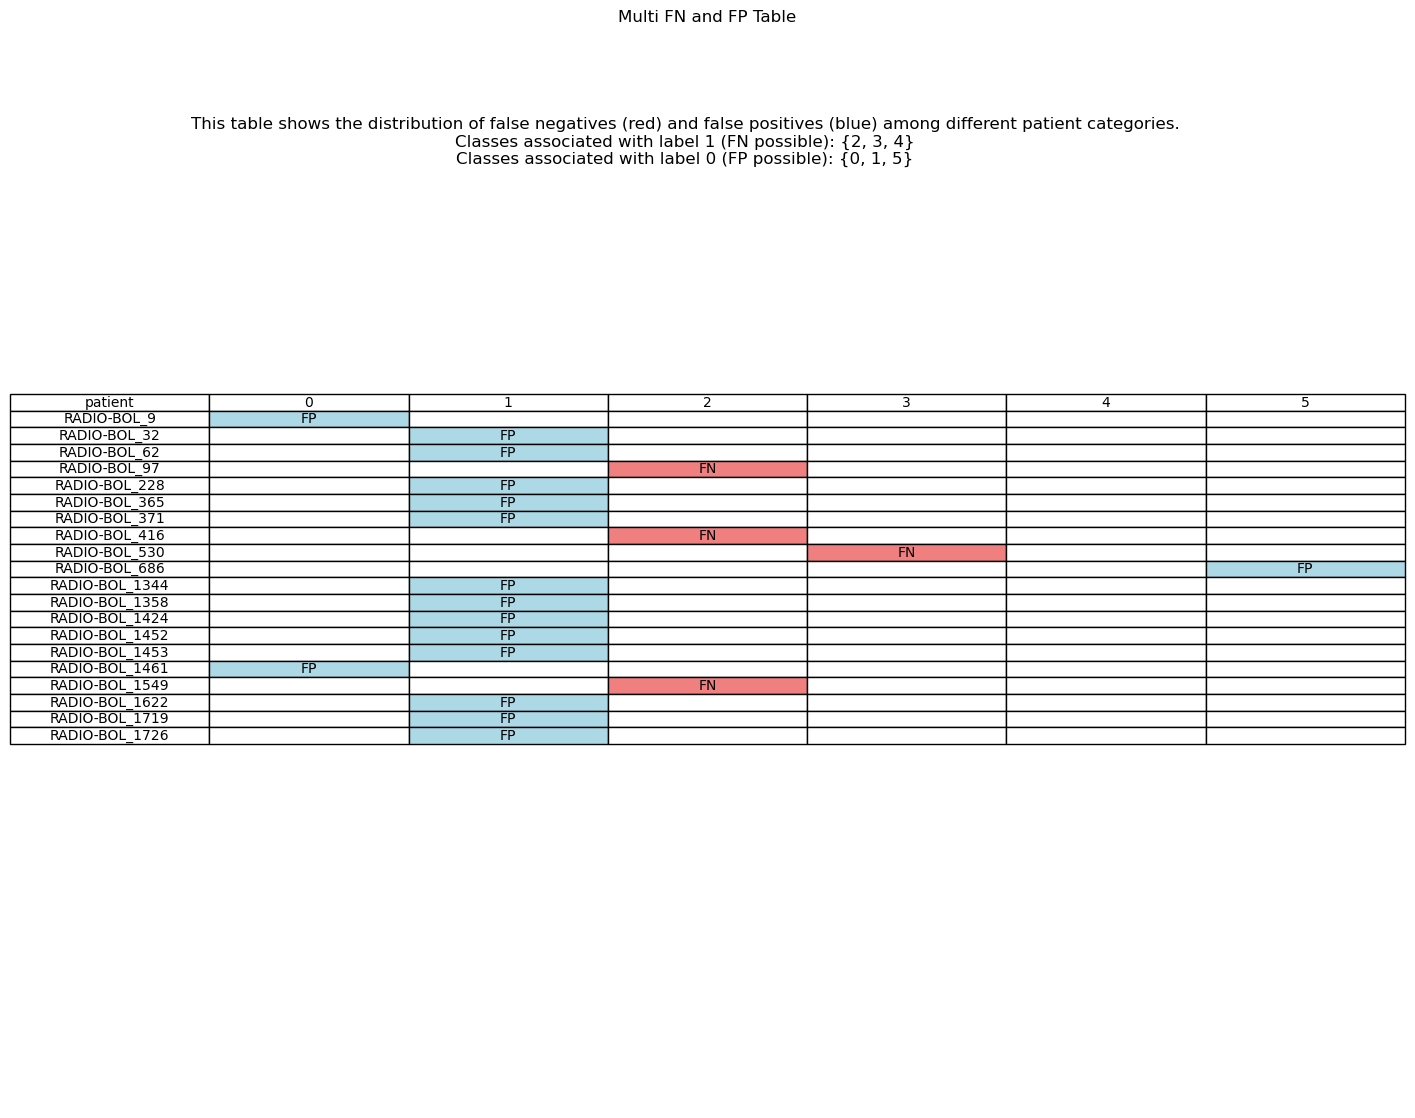

In [34]:
from Components import ErrorAnalysis
IDs_FN = ErrorAnalysis.IDs_FN(predictions,y_test,ids_test)
IDs_FP = ErrorAnalysis.IDs_FP(predictions,y_test,ids_test)

TableSubTypesErrors(morf_codificata_test, IDs_FN , IDs_FP , ids_test, size = "Large")

# Fold 1

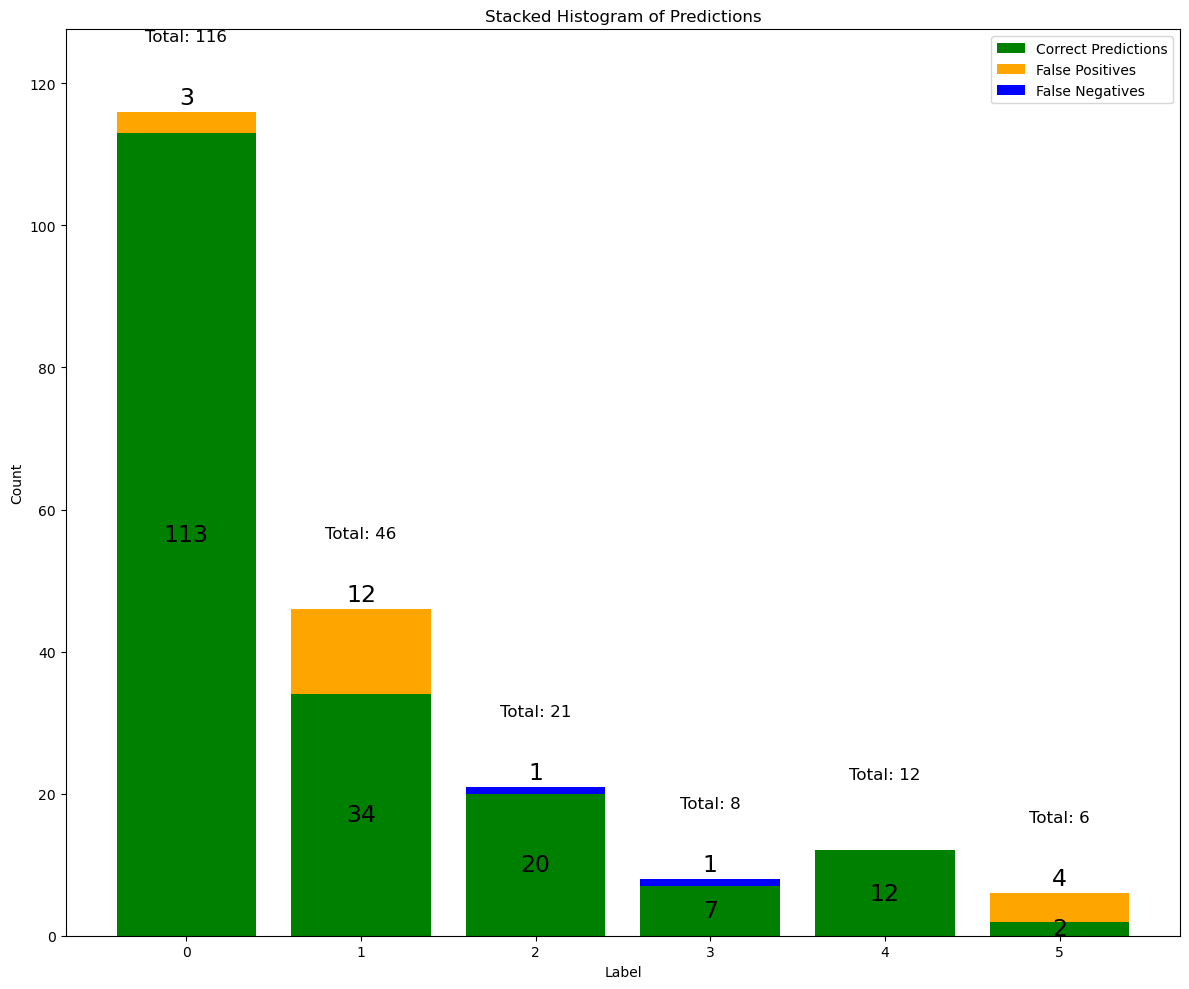

In [36]:
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
# Loading the dataset;
db = pd.read_csv("../nested_CV/fold_1_test_set.csv")
path = "../Elements/Boruta_RusBoost/AcrossSplits/Split1_Boruta_RusBoostFitted_pipeline.pkl"
# removing the id and the subtypes of a given dataset
def extract_PATIENT_INFO(db):
   ids =  db.pop("ID")
   morf_codificata = db.pop("morf_codificata")
   luogoTc= db.pop("luogoTC_codificato")
   return db, ids, morf_codificata, luogoTc

# extrating the label
y_test = db.pop("label")
X_test = db

loaded_pipeline = joblib.load(path) # to load the model


X_test, ids_test, morf_codificata_test, luogoTc = extract_PATIENT_INFO(X_test) #to remove the patient infos

predictions = loaded_pipeline.predict(X_test)

from Components import ErrorAnalysis
ErrorAnalysis.StackedHist(predictions=predictions, y_test=y_test, morf_codificata_test=morf_codificata_test)

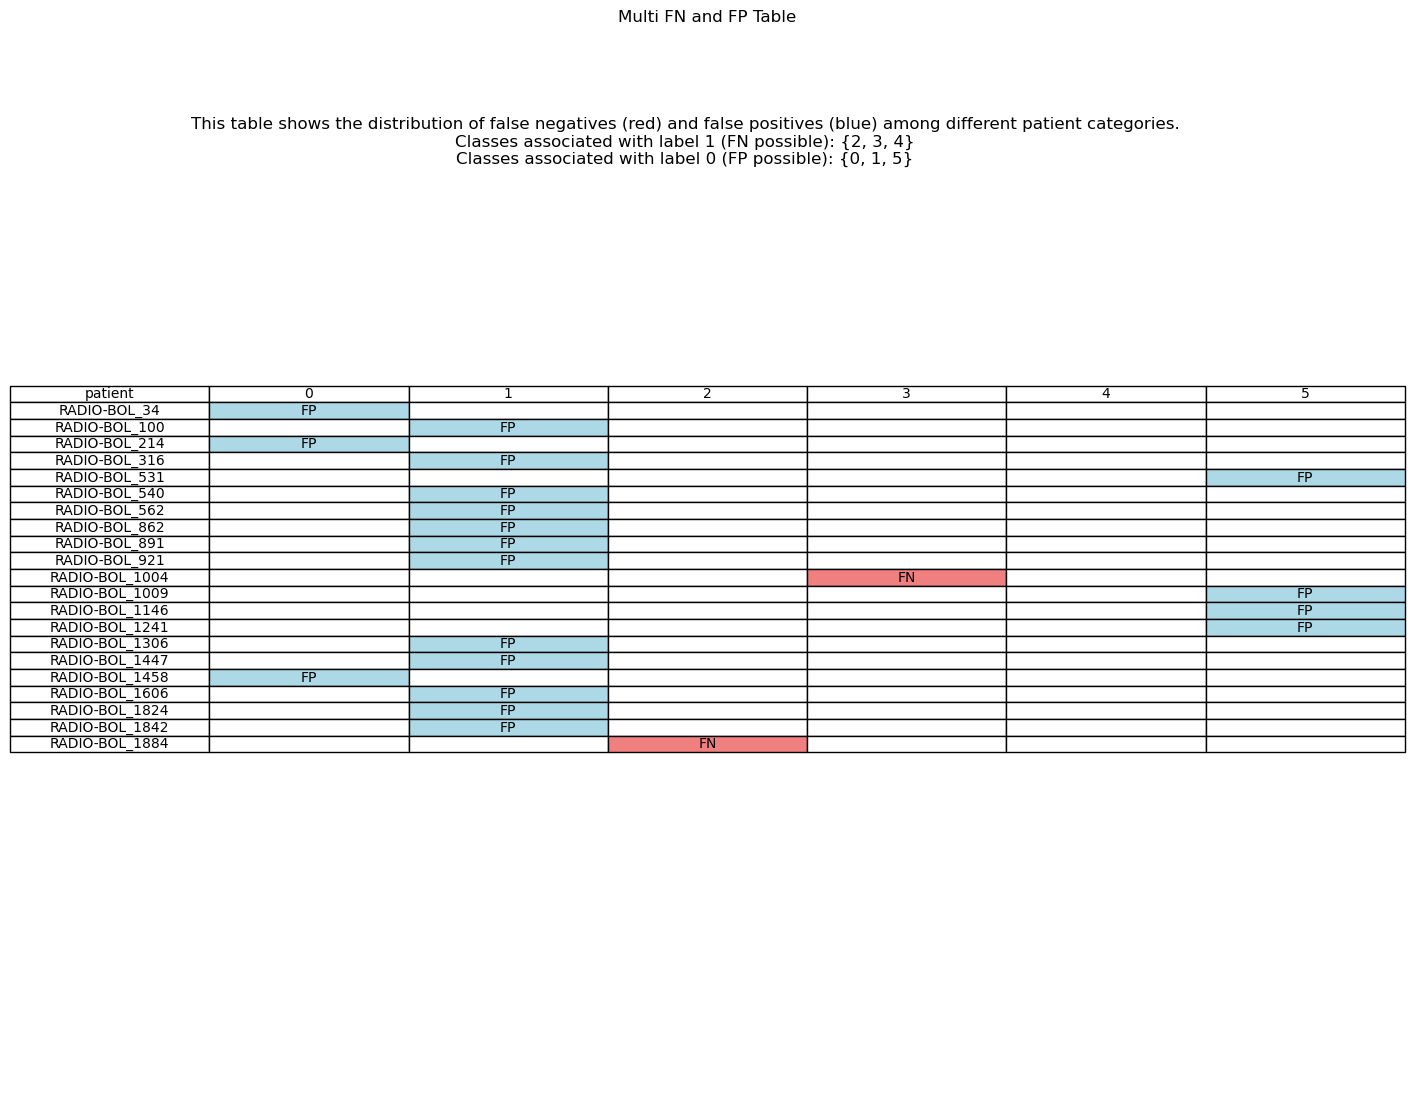

In [37]:
IDs_FN = ErrorAnalysis.IDs_FN(predictions,y_test,ids_test)
IDs_FP = ErrorAnalysis.IDs_FP(predictions,y_test,ids_test)

TableSubTypesErrors(morf_codificata_test, IDs_FN , IDs_FP , ids_test, size = "Large")

# Fold 2

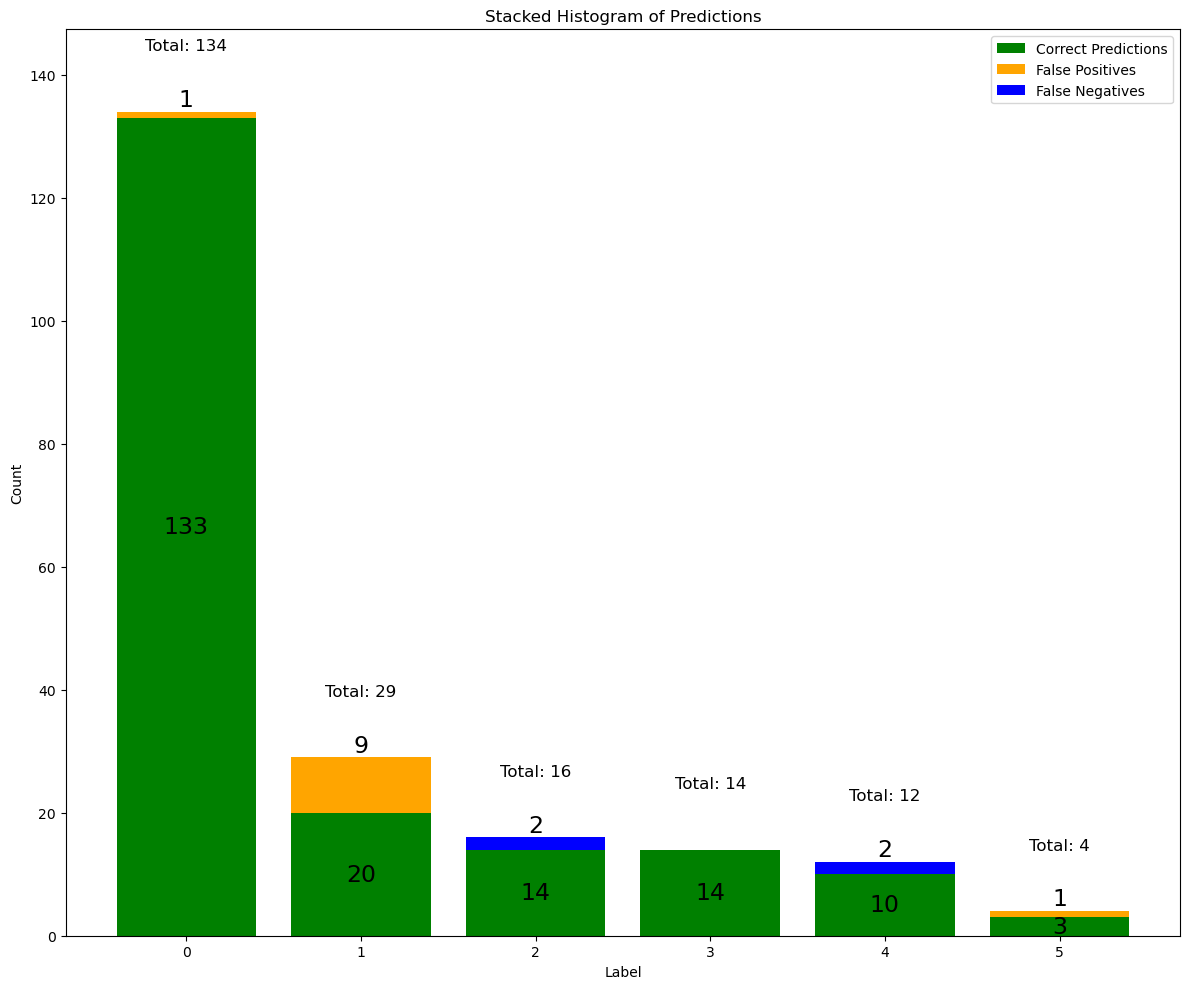

In [38]:
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
# Loading the dataset;
db = pd.read_csv("../nested_CV/fold_2_test_set.csv")
path = "../Elements/Boruta_RusBoost/AcrossSplits/Split2_Boruta_RusBoostFitted_pipeline.pkl"
# removing the id and the subtypes of a given dataset
def extract_PATIENT_INFO(db):
   ids =  db.pop("ID")
   morf_codificata = db.pop("morf_codificata")
   luogoTc= db.pop("luogoTC_codificato")
   return db, ids, morf_codificata, luogoTc

# extrating the label
y_test = db.pop("label")
X_test = db

loaded_pipeline = joblib.load(path) # to load the model


X_test, ids_test, morf_codificata_test, luogoTc = extract_PATIENT_INFO(X_test) #to remove the patient infos

predictions = loaded_pipeline.predict(X_test)

from Components import ErrorAnalysis
ErrorAnalysis.StackedHist(predictions=predictions, y_test=y_test, morf_codificata_test=morf_codificata_test)

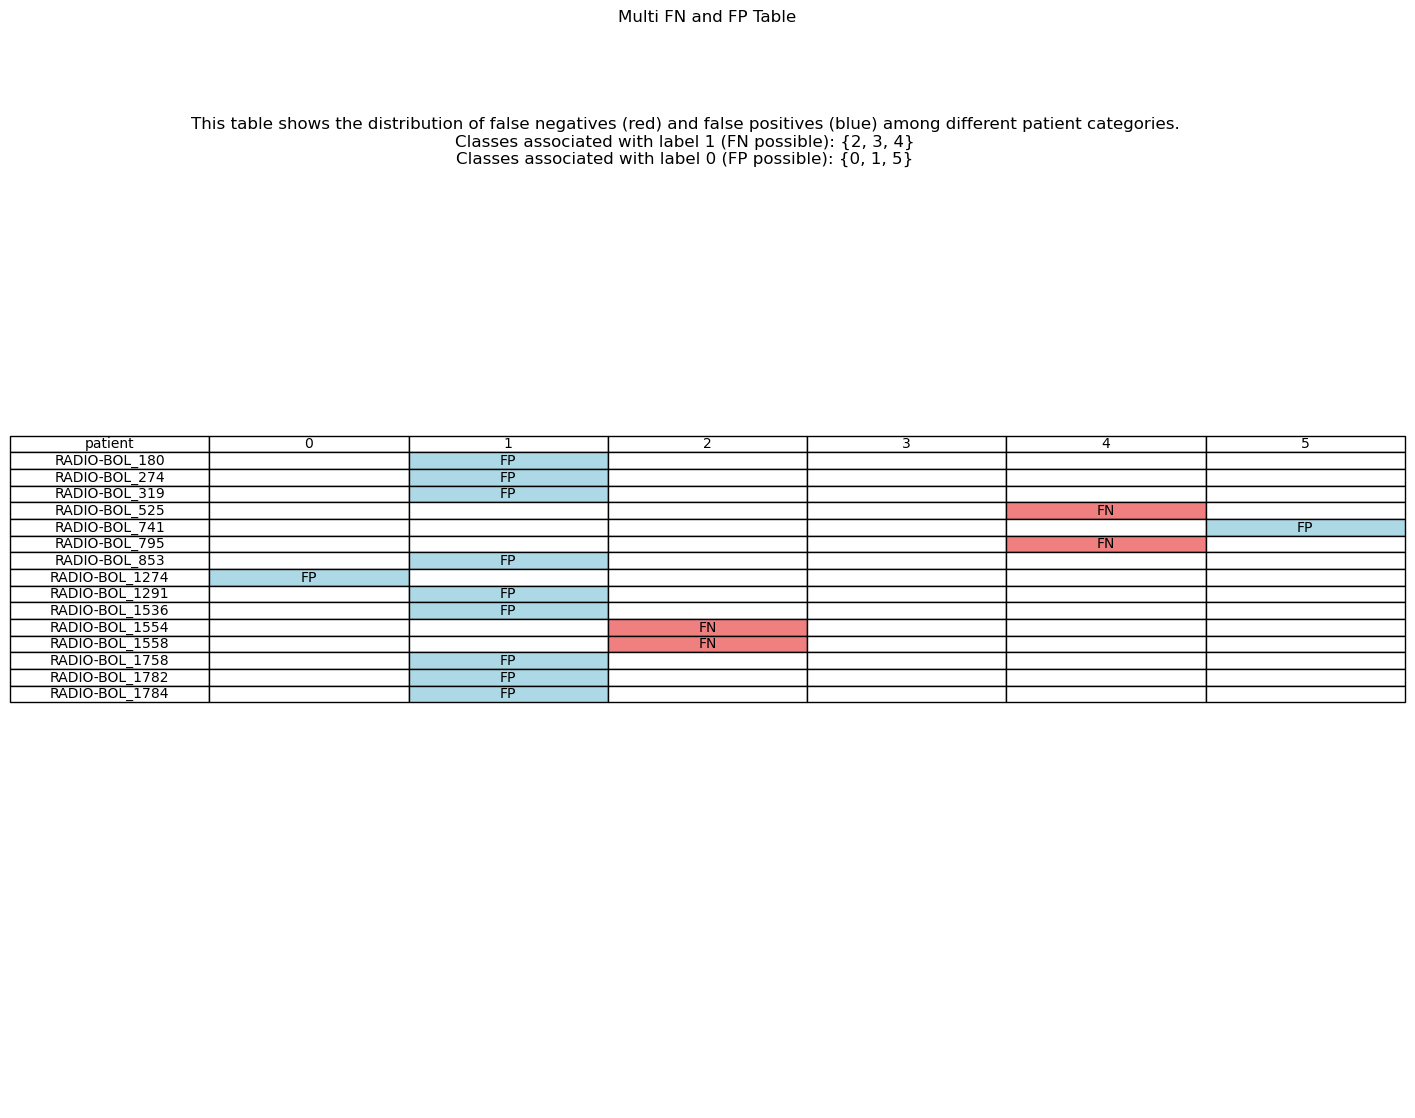

In [39]:
IDs_FN = ErrorAnalysis.IDs_FN(predictions,y_test,ids_test)
IDs_FP = ErrorAnalysis.IDs_FP(predictions,y_test,ids_test)

TableSubTypesErrors(morf_codificata_test, IDs_FN , IDs_FP , ids_test, size = "Large")

# Fold 3

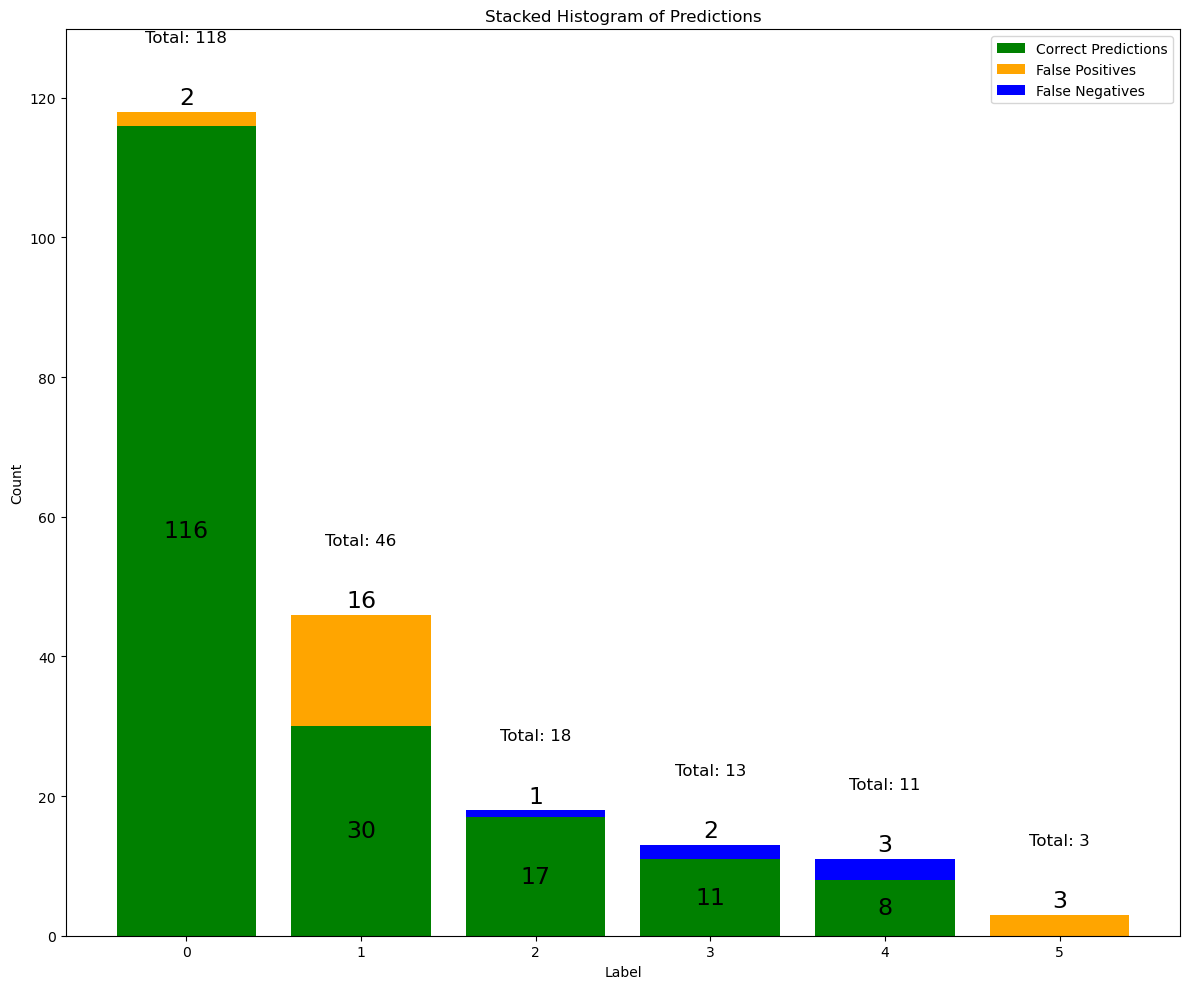

In [40]:
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
# Loading the dataset;
db = pd.read_csv("../nested_CV/fold_3_test_set.csv")
path = "../Elements/Boruta_RusBoost/AcrossSplits/Split3_Boruta_RusBoostFitted_pipeline.pkl"
# removing the id and the subtypes of a given dataset
def extract_PATIENT_INFO(db):
   ids =  db.pop("ID")
   morf_codificata = db.pop("morf_codificata")
   luogoTc= db.pop("luogoTC_codificato")
   return db, ids, morf_codificata, luogoTc

# extrating the label
y_test = db.pop("label")
X_test = db

loaded_pipeline = joblib.load(path) # to load the model


X_test, ids_test, morf_codificata_test, luogoTc = extract_PATIENT_INFO(X_test) #to remove the patient infos

predictions = loaded_pipeline.predict(X_test)

from Components import ErrorAnalysis
ErrorAnalysis.StackedHist(predictions=predictions, y_test=y_test, morf_codificata_test=morf_codificata_test)

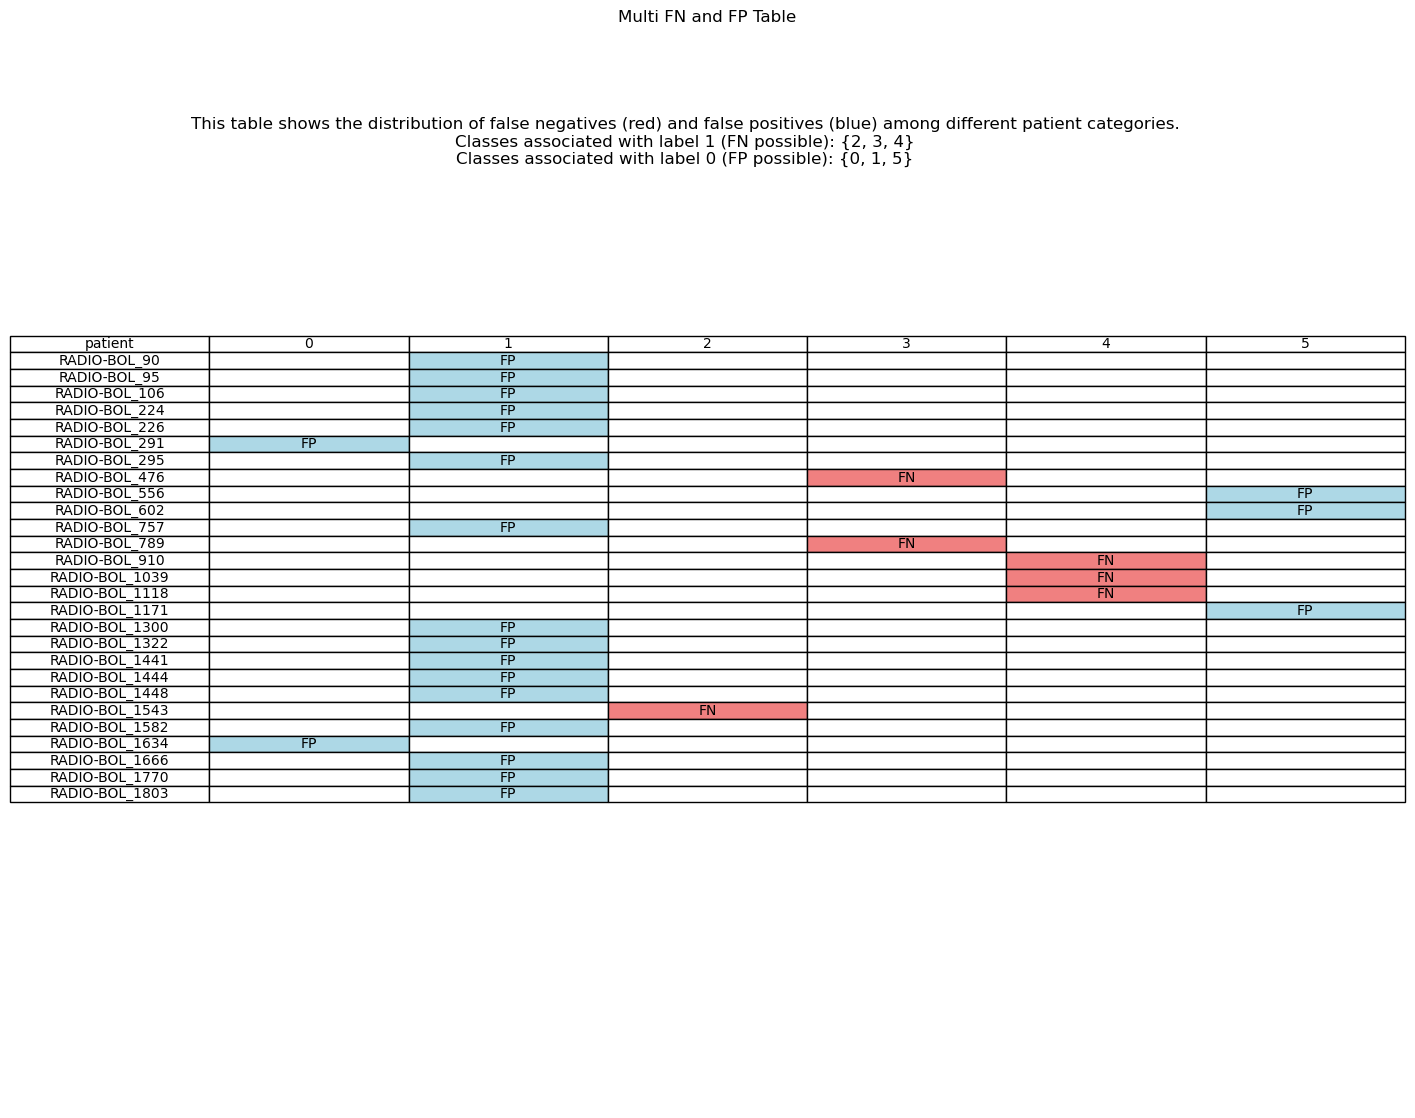

In [41]:
IDs_FN = ErrorAnalysis.IDs_FN(predictions,y_test,ids_test)
IDs_FP = ErrorAnalysis.IDs_FP(predictions,y_test,ids_test)

TableSubTypesErrors(morf_codificata_test, IDs_FN , IDs_FP , ids_test, size = "Large")

# Fold 4

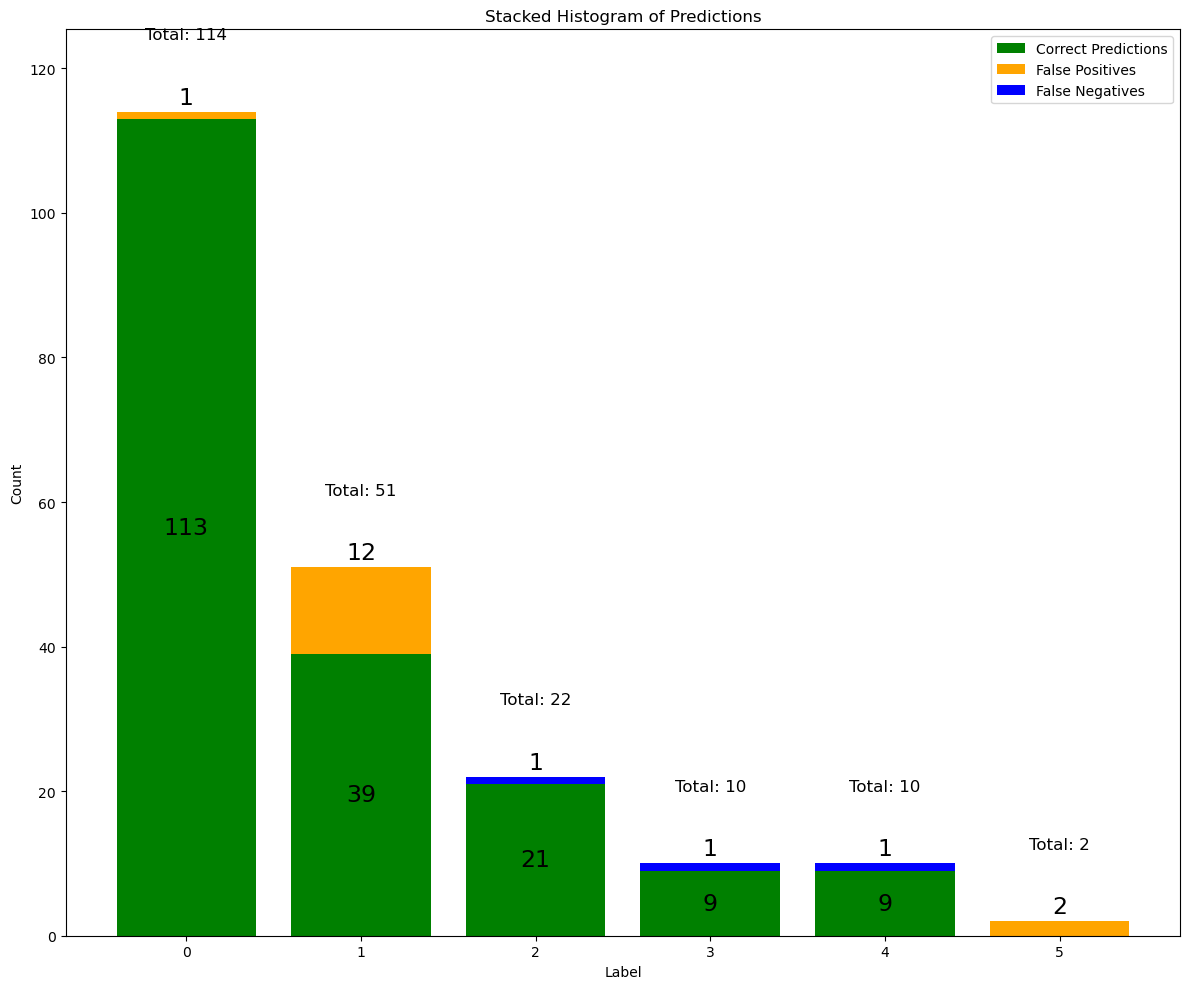

In [42]:
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
# Loading the dataset;
db = pd.read_csv("../nested_CV/fold_4_test_set.csv")
path = "../Elements/Boruta_RusBoost/AcrossSplits/Split4_Boruta_RusBoostFitted_pipeline.pkl"
# removing the id and the subtypes of a given dataset
def extract_PATIENT_INFO(db):
   ids =  db.pop("ID")
   morf_codificata = db.pop("morf_codificata")
   luogoTc= db.pop("luogoTC_codificato")
   return db, ids, morf_codificata, luogoTc

# extrating the label
y_test = db.pop("label")
X_test = db

loaded_pipeline = joblib.load(path) # to load the model


X_test, ids_test, morf_codificata_test, luogoTc = extract_PATIENT_INFO(X_test) #to remove the patient infos

predictions = loaded_pipeline.predict(X_test)

from Components import ErrorAnalysis
ErrorAnalysis.StackedHist(predictions=predictions, y_test=y_test, morf_codificata_test=morf_codificata_test)

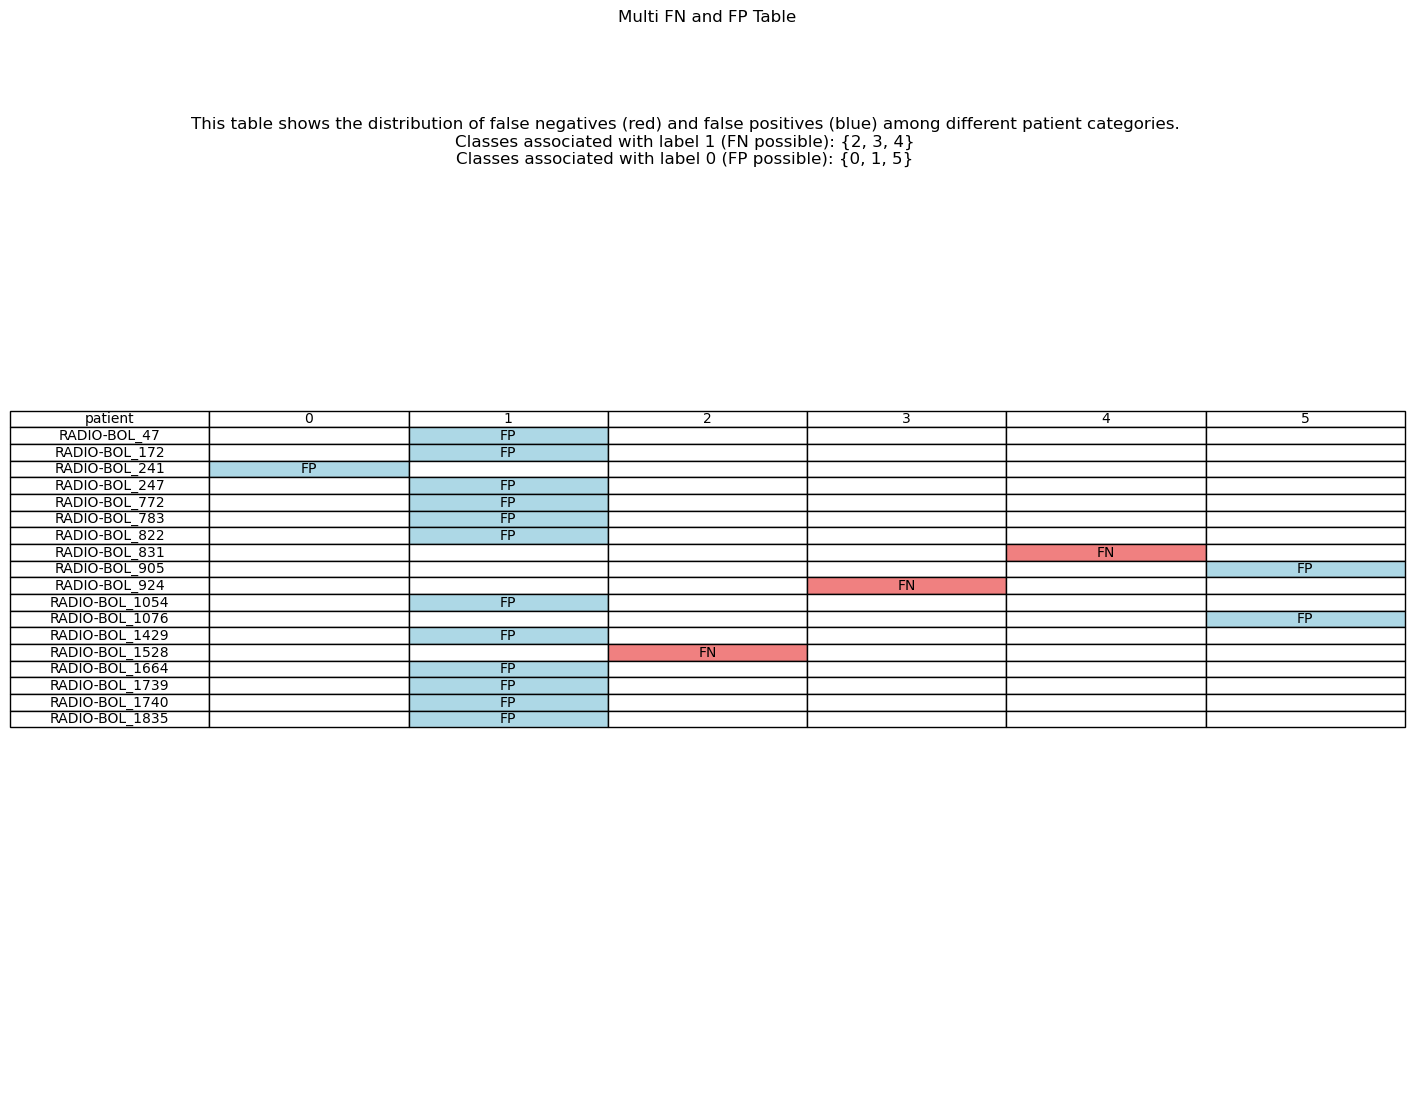

In [43]:
IDs_FN = ErrorAnalysis.IDs_FN(predictions,y_test,ids_test)
IDs_FP = ErrorAnalysis.IDs_FP(predictions,y_test,ids_test)

TableSubTypesErrors(morf_codificata_test, IDs_FN , IDs_FP , ids_test, size = "Large")